# Введение

Оператор связи **«ТелеДом»** хочет снизить отток клиентов. Чтобы предлагать пользователям промокоды и специальные условия до того, как они решат уйти, компании нужна модель, которая предскажет вероятность расторжения договора.  

Для этого в распоряжении есть данные о клиентах, их тарифах и дополнительных услугах. Задача — обучить модель машинного обучения, которая поможет заранее определять абонентов, склонных к уходу.  

В рамках проекта нужно:  
- Подготовить и изучить данные;  
- Выбрать и обучить подходящую модель;  
- Оценить точность предсказаний;  
- Предложить решения по снижению оттока.  

Эта модель поможет **«ТелеДому»** вовремя реагировать на риск ухода клиентов и предлагать им выгодные условия для продолжения использования услуг.

## 1. Загрузка данных

In [50]:
!pip install seaborn

In [51]:
import os
import pandas as pd
import numpy as np
import sqlite3
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Путь к базе данных
path = os.path.expanduser('~/final/')
path_to_db = os.path.join(path, 'ds-plus-final.db')

In [3]:
# Создаем соединение SQLite3
conn = sqlite3.connect(path_to_db)

In [4]:
# Получаем список таблиц
tables_list = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(list(tables_list['name']))

['data_arc', 'data_bulk', 'data_bulk_time', 'data_wire_time', 'contract', 'personal', 'phone', 'internet', 'data_gas', 'data_temp', 'data_wire']


In [5]:
# Функция для загрузки таблиц
def load_tables(conn, table_names):
    for table_name in table_names:
        query = f"SELECT * FROM {table_name};"
        df = pd.read_sql(query, conn)  # Используем соединение SQLite3
        globals()[f"{table_name}_df"] = df  # Создаем глобальную переменную

In [6]:
# Загружаем таблицы
table_names = ['contract', 'personal', 'phone', 'internet']
load_tables(conn, table_names)

# Закрываем соединение
conn.close()

In [7]:
contract_df

customerID   BeginDate EndDate            Type PaperlessBilling  \
0     7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1     5575-GNVDE  2017-04-01      No        One year               No   
2     3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3     7795-CFOCW  2016-05-01      No        One year               No   
4     9237-HQITU  2019-09-01      No  Month-to-month              Yes   
...          ...         ...     ...             ...              ...   
7038  6840-RESVB  2018-02-01      No        One year              Yes   
7039  2234-XADUH  2014-02-01      No        One year              Yes   
7040  4801-JZAZL  2019-03-01      No  Month-to-month              Yes   
7041  8361-LTMKD  2019-07-01      No  Month-to-month              Yes   
7042  3186-AJIEK  2014-08-01      No        Two year              Yes   

                  PaymentMethod MonthlyCharges TotalCharges  
0              Electronic check          29.85        31.04  
1                  Mailed check          56.95      2071.84  
2                  Mailed check          53.85       226.17  
3     Bank transfer (automatic)           42.3       1960.6  
4              Electronic check           70.7        353.5  
...                         ...            ...          ...  
7038               Mailed check           84.8       2035.2  
7039    Credit card (automatic)          103.2       7430.4  
7040           Electronic check           29.6        325.6  
7041               Mailed check           74.4        520.8  
7042  Bank transfer (automatic)         105.65      7251.82  

[7043 rows x 8 columns]

In [8]:
personal_df

customerID  gender SeniorCitizen Partner Dependents
0     7590-VHVEG  Female             0     Yes         No
1     5575-GNVDE    Male             0      No         No
2     3668-QPYBK    Male             0      No         No
3     7795-CFOCW    Male             0      No         No
4     9237-HQITU  Female             0      No         No
...          ...     ...           ...     ...        ...
7038  6840-RESVB    Male             0     Yes        Yes
7039  2234-XADUH  Female             0     Yes        Yes
7040  4801-JZAZL  Female             0     Yes        Yes
7041  8361-LTMKD    Male             1     Yes         No
7042  3186-AJIEK    Male             0      No         No

[7043 rows x 5 columns]

In [9]:
internet_df

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0     7590-VHVEG             DSL             No          Yes               No   
1     5575-GNVDE             DSL            Yes           No              Yes   
2     3668-QPYBK             DSL            Yes          Yes               No   
3     7795-CFOCW             DSL            Yes           No              Yes   
4     9237-HQITU     Fiber optic             No           No               No   
...          ...             ...            ...          ...              ...   
5512  6840-RESVB             DSL            Yes           No              Yes   
5513  2234-XADUH     Fiber optic             No          Yes              Yes   
5514  4801-JZAZL             DSL            Yes           No               No   
5515  8361-LTMKD     Fiber optic             No           No               No   
5516  3186-AJIEK     Fiber optic            Yes           No              Yes   

     TechSupport StreamingTV StreamingMovies  
0             No          No              No  
1             No          No              No  
2             No          No              No  
3            Yes          No              No  
4             No          No              No  
...          ...         ...             ...  
5512         Yes         Yes             Yes  
5513          No         Yes             Yes  
5514          No          No              No  
5515          No          No              No  
5516         Yes         Yes             Yes  

[5517 rows x 8 columns]

In [10]:
phone_df

CustomerId MultipleLines
0     5575-GNVDE            No
1     3668-QPYBK            No
2     9237-HQITU            No
3     9305-CDSKC           Yes
4     1452-KIOVK           Yes
...          ...           ...
6356  2569-WGERO            No
6357  6840-RESVB           Yes
6358  2234-XADUH           Yes
6359  8361-LTMKD           Yes
6360  3186-AJIEK            No

[6361 rows x 2 columns]

# Описание данных

Данные хранятся в **SQLite** — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

- **contract** — информация о договорах;
- **personal** — персональные данные клиентов;
- **internet** — информация об интернет-услугах;
- **phone** — информация об услугах телефонии.

---

## Таблица `contract`
| Поле               | Описание                                      |
|--------------------|----------------------------------------------|
| `customerID`      | ID абонента                                  |
| `BeginDate`       | Дата начала действия договора               |
| `EndDate`         | Дата окончания действия договора            |
| `Type`            | Тип оплаты: раз в год-два или ежемесячно    |
| `PaperlessBilling`| Электронный расчётный лист                  |
| `PaymentMethod`   | Тип платежа                                 |
| `MonthlyCharges`  | Расходы за месяц                           |
| `TotalCharges`    | Общие расходы абонента                     |

---

## Таблица `personal`
| Поле            | Описание                              |
|----------------|--------------------------------------|
| `customerID`  | ID пользователя                      |
| `gender`      | Пол                                  |
| `SeniorCitizen` | Является ли абонент пенсионером   |
| `Partner`     | Есть ли у абонента супруг(а)       |
| `Dependents`  | Есть ли у абонента дети            |

---

## Таблица `internet`
| Поле              | Описание                                      |
|------------------|----------------------------------------------|
| `customerID`    | ID пользователя                              |
| `InternetService` | Тип подключения                           |
| `OnlineSecurity` | Блокировка опасных сайтов                 |
| `OnlineBackup`   | Облачное хранилище файлов                 |
| `DeviceProtection` | Антивирус                               |
| `TechSupport`    | Выделенная линия технической поддержки    |
| `StreamingTV`    | Стриминговое телевидение                  |
| `StreamingMovies` | Каталог фильмов                         |

---

## Таблица `phone`
| Поле             | Описание                                      |
|-----------------|----------------------------------------------|
| `customerID`   | ID пользователя                              |
| `MultipleLines` | Подключение телефона к нескольким линиям   |

---

📅 **Информация о договорах актуальна на 1 февраля 2020.**


## 2. Исследовательский анализ  и предобработка данных

In [11]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


In [12]:
contract_df.describe()

customerID   BeginDate EndDate            Type PaperlessBilling  \
count         7043        7043    7043            7043             7043   
unique        7043          77      67               3                2   
top     3186-AJIEK  2014-02-01      No  Month-to-month              Yes   
freq             1         366    5942            3875             4171   

           PaymentMethod MonthlyCharges TotalCharges  
count               7043           7043         7043  
unique                 4           1585         6658  
top     Electronic check          20.05               
freq                2365             61           11

In [13]:
print('Типы оплаты: ', ', '.join(contract_df['Type'].unique()))
print('Наличие электронного расчётного листа: ', ', '.join(contract_df['PaperlessBilling'].unique()))
print('Тип платежа: ', ', '.join(contract_df['PaymentMethod'].unique()))

Типы оплаты:  Month-to-month, One year, Two year
Наличие электронного расчётного листа:  Yes, No
Тип платежа:  Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)


In [14]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [15]:
personal_df.describe()

customerID gender SeniorCitizen Partner Dependents
count         7043   7043          7043    7043       7043
unique        7043      2             2       2          2
top     3186-AJIEK   Male             0      No         No
freq             1   3555          5901    3641       4933

In [16]:
print('Пол: ', ', '.join(personal_df['gender'].unique()))
print('Является ли абонент пенсионером: ', ', '.join(personal_df['SeniorCitizen'].unique()))
print('Есть ли у абонента супруг(а): ', ', '.join(personal_df['Partner'].unique()))
print('Есть ли у абонента дети: ', ', '.join(personal_df['Dependents'].unique()))

Пол:  Female, Male
Является ли абонент пенсионером:  0, 1
Есть ли у абонента супруг(а):  Yes, No
Есть ли у абонента дети:  No, Yes


In [17]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [18]:
internet_df.describe()

customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     3186-AJIEK     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

In [19]:
print('Тип подключения: ', ', '.join(internet_df['InternetService'].unique()))
print('Блокировка опасных сайтов: ', ', '.join(internet_df['OnlineSecurity'].unique()))
print('Облачное хранилище сайтов: ', ', '.join(internet_df['OnlineBackup'].unique()))
print('Антивирус: ', ', '.join(internet_df['DeviceProtection'].unique()))
print('Выделенная линия технической поддержки: ', ', '.join(internet_df['TechSupport'].unique()))
print('Стриминговое телевидение: ', ', '.join(internet_df['StreamingTV'].unique()))
print('Каталог фильмов: ', ', '.join(internet_df['StreamingMovies'].unique()))

Тип подключения:  DSL, Fiber optic
Блокировка опасных сайтов:  No, Yes
Облачное хранилище сайтов:  Yes, No
Антивирус:  No, Yes
Выделенная линия технической поддержки:  No, Yes
Стриминговое телевидение:  No, Yes
Каталог фильмов:  No, Yes


In [20]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [21]:
print('Количество уникальных абонентов: ', phone_df['CustomerId'].nunique())
print('Подключение телефона к нескольким линиям: ', ', '.join(phone_df['MultipleLines'].unique()))

Количество уникальных абонентов:  6361
Подключение телефона к нескольким линиям:  No, Yes


### Вывод
В таблицах отсутствуют пропуски и дубликаты. Необходимо преобразовать все даты (`BeginDate`, `EndDate`) в формат `datetime64`, числовые значения (`MonthlyCharges`, `TotalCharges`) в `float` или `int`, а бинарные признаки (`Partner`, `Dependents`, `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `SeniorCitizen`, `PaperlessBilling`) в `bool`, заменив `Yes` на `True`, а `No` на `False`.

In [22]:
merged_df = contract_df.merge(
    personal_df, on='customerID', how='left').merge(
    internet_df, on='customerID', how='left').merge(
    phone_df, left_on='customerID', right_on='CustomerId', how='left')

merged_df

customerID   BeginDate EndDate            Type PaperlessBilling  \
0     7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1     5575-GNVDE  2017-04-01      No        One year               No   
2     3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3     7795-CFOCW  2016-05-01      No        One year               No   
4     9237-HQITU  2019-09-01      No  Month-to-month              Yes   
...          ...         ...     ...             ...              ...   
7038  6840-RESVB  2018-02-01      No        One year              Yes   
7039  2234-XADUH  2014-02-01      No        One year              Yes   
7040  4801-JZAZL  2019-03-01      No  Month-to-month              Yes   
7041  8361-LTMKD  2019-07-01      No  Month-to-month              Yes   
7042  3186-AJIEK  2014-08-01      No        Two year              Yes   

                  PaymentMethod MonthlyCharges TotalCharges  gender  \
0              Electronic check          29.85        31.04  Female   
1                  Mailed check          56.95      2071.84    Male   
2                  Mailed check          53.85       226.17    Male   
3     Bank transfer (automatic)           42.3       1960.6    Male   
4              Electronic check           70.7        353.5  Female   
...                         ...            ...          ...     ...   
7038               Mailed check           84.8       2035.2    Male   
7039    Credit card (automatic)          103.2       7430.4  Female   
7040           Electronic check           29.6        325.6  Female   
7041               Mailed check           74.4        520.8    Male   
7042  Bank transfer (automatic)         105.65      7251.82    Male   

     SeniorCitizen  ... Dependents InternetService OnlineSecurity  \
0                0  ...         No             DSL             No   
1                0  ...         No             DSL            Yes   
2                0  ...         No             DSL            Yes   
3                0  ...         No             DSL            Yes   
4                0  ...         No     Fiber optic             No   
...            ...  ...        ...             ...            ...   
7038             0  ...        Yes             DSL            Yes   
7039             0  ...        Yes     Fiber optic             No   
7040             0  ...        Yes             DSL            Yes   
7041             1  ...         No     Fiber optic             No   
7042             0  ...         No     Fiber optic            Yes   

     OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0             Yes               No          No          No              No   
1              No              Yes          No          No              No   
2             Yes               No          No          No              No   
3              No              Yes         Yes          No              No   
4              No               No          No          No              No   
...           ...              ...         ...         ...             ...   
7038           No              Yes         Yes         Yes             Yes   
7039          Yes              Yes          No         Yes             Yes   
7040           No               No          No          No              No   
7041           No               No          No          No              No   
7042           No              Yes         Yes         Yes             Yes   

      CustomerId MultipleLines  
0            NaN           NaN  
1     5575-GNVDE            No  
2     3668-QPYBK            No  
3            NaN           NaN  
4     9237-HQITU            No  
...          ...           ...  
7038  6840-RESVB           Yes  
7039  2234-XADUH           Yes  
7040         NaN           NaN  
7041  8361-LTMKD           Yes  
7042  3186-AJIEK            No  

[7043 rows x 21 columns]

In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
 8   gender            7043 non-null   object
 9   SeniorCitizen     7043 non-null   object
 10  Partner           7043 non-null   object
 11  Dependents        7043 non-null   object
 12  InternetService   5517 non-null   object
 13  OnlineSecurity    5517 non-null   object
 14  OnlineBackup      5517 non-null   object
 15  DeviceProtection  5517 non-null   object
 16  TechSupport       5517 non-null   object
 17  StreamingTV   

In [24]:
merged_df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
CustomerId           682
MultipleLines        682
dtype: int64

In [25]:
merged_df.drop(columns=['customerID','CustomerId'], axis=1, inplace=True)

In [26]:
merged_df.fillna({'InternetService' : False, 
                  'OnlineSecurity' : False, 
                  'OnlineBackup' : False,
                  'DeviceProtection' : False, 
                  'TechSupport' : False, 
                  'StreamingTV' : False, 
                  'StreamingMovies' : False,
                  'MultipleLines' : False}, inplace=True)

In [27]:
merged_df.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [28]:
merged_df

BeginDate EndDate            Type PaperlessBilling  \
0     2020-01-01      No  Month-to-month              Yes   
1     2017-04-01      No        One year               No   
2     2019-10-01      No  Month-to-month              Yes   
3     2016-05-01      No        One year               No   
4     2019-09-01      No  Month-to-month              Yes   
...          ...     ...             ...              ...   
7038  2018-02-01      No        One year              Yes   
7039  2014-02-01      No        One year              Yes   
7040  2019-03-01      No  Month-to-month              Yes   
7041  2019-07-01      No  Month-to-month              Yes   
7042  2014-08-01      No        Two year              Yes   

                  PaymentMethod MonthlyCharges TotalCharges  gender  \
0              Electronic check          29.85        31.04  Female   
1                  Mailed check          56.95      2071.84    Male   
2                  Mailed check          53.85       226.17    Male   
3     Bank transfer (automatic)           42.3       1960.6    Male   
4              Electronic check           70.7        353.5  Female   
...                         ...            ...          ...     ...   
7038               Mailed check           84.8       2035.2    Male   
7039    Credit card (automatic)          103.2       7430.4  Female   
7040           Electronic check           29.6        325.6  Female   
7041               Mailed check           74.4        520.8    Male   
7042  Bank transfer (automatic)         105.65      7251.82    Male   

     SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0                0     Yes         No             DSL             No   
1                0      No         No             DSL            Yes   
2                0      No         No             DSL            Yes   
3                0      No         No             DSL            Yes   
4                0      No         No     Fiber optic             No   
...            ...     ...        ...             ...            ...   
7038             0     Yes        Yes             DSL            Yes   
7039             0     Yes        Yes     Fiber optic             No   
7040             0     Yes        Yes             DSL            Yes   
7041             1     Yes         No     Fiber optic             No   
7042             0      No         No     Fiber optic            Yes   

     OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0             Yes               No          No          No              No   
1              No              Yes          No          No              No   
2             Yes               No          No          No              No   
3              No              Yes         Yes          No              No   
4              No               No          No          No              No   
...           ...              ...         ...         ...             ...   
7038           No              Yes         Yes         Yes             Yes   
7039          Yes              Yes          No         Yes             Yes   
7040           No               No          No          No              No   
7041           No               No          No          No              No   
7042           No              Yes         Yes         Yes             Yes   

     MultipleLines  
0            False  
1               No  
2               No  
3            False  
4               No  
...            ...  
7038           Yes  
7039           Yes  
7040         False  
7041           Yes  
7042            No  

[7043 rows x 19 columns]

In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BeginDate         7043 non-null   object
 1   EndDate           7043 non-null   object
 2   Type              7043 non-null   object
 3   PaperlessBilling  7043 non-null   object
 4   PaymentMethod     7043 non-null   object
 5   MonthlyCharges    7043 non-null   object
 6   TotalCharges      7043 non-null   object
 7   gender            7043 non-null   object
 8   SeniorCitizen     7043 non-null   object
 9   Partner           7043 non-null   object
 10  Dependents        7043 non-null   object
 11  InternetService   7043 non-null   object
 12  OnlineSecurity    7043 non-null   object
 13  OnlineBackup      7043 non-null   object
 14  DeviceProtection  7043 non-null   object
 15  TechSupport       7043 non-null   object
 16  StreamingTV       7043 non-null   object
 17  StreamingMovie

In [30]:
cols_to_replace = merged_df.columns.difference(['EndDate'])
df_new = merged_df.copy()
df_new[cols_to_replace] = df_new[cols_to_replace].replace({'No': False, 'Yes': True, '0': False, '1': True})
df_new

C:\Users\user\AppData\Local\Temp\ipykernel_20268\1190123038.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new[cols_to_replace] = df_new[cols_to_replace].replace({'No': False, 'Yes': True, '0': False, '1': True})


BeginDate EndDate            Type  PaperlessBilling  \
0     2020-01-01      No  Month-to-month              True   
1     2017-04-01      No        One year             False   
2     2019-10-01      No  Month-to-month              True   
3     2016-05-01      No        One year             False   
4     2019-09-01      No  Month-to-month              True   
...          ...     ...             ...               ...   
7038  2018-02-01      No        One year              True   
7039  2014-02-01      No        One year              True   
7040  2019-03-01      No  Month-to-month              True   
7041  2019-07-01      No  Month-to-month              True   
7042  2014-08-01      No        Two year              True   

                  PaymentMethod MonthlyCharges TotalCharges  gender  \
0              Electronic check          29.85        31.04  Female   
1                  Mailed check          56.95      2071.84    Male   
2                  Mailed check          53.85       226.17    Male   
3     Bank transfer (automatic)           42.3       1960.6    Male   
4              Electronic check           70.7        353.5  Female   
...                         ...            ...          ...     ...   
7038               Mailed check           84.8       2035.2    Male   
7039    Credit card (automatic)          103.2       7430.4  Female   
7040           Electronic check           29.6        325.6  Female   
7041               Mailed check           74.4        520.8    Male   
7042  Bank transfer (automatic)         105.65      7251.82    Male   

      SeniorCitizen  Partner  Dependents InternetService  OnlineSecurity  \
0             False     True       False             DSL           False   
1             False    False       False             DSL            True   
2             False    False       False             DSL            True   
3             False    False       False             DSL            True   
4             False    False       False     Fiber optic           False   
...             ...      ...         ...             ...             ...   
7038          False     True        True             DSL            True   
7039          False     True        True     Fiber optic           False   
7040          False     True        True             DSL            True   
7041           True     True       False     Fiber optic           False   
7042          False    False       False     Fiber optic            True   

      OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0             True             False        False        False   
1            False              True        False        False   
2             True             False        False        False   
3            False              True         True        False   
4            False             False        False        False   
...            ...               ...          ...          ...   
7038         False              True         True         True   
7039          True              True        False         True   
7040         False             False        False        False   
7041         False             False        False        False   
7042         False              True         True         True   

      StreamingMovies  MultipleLines  
0               False          False  
1               False          False  
2               False          False  
3               False          False  
4               False          False  
...               ...            ...  
7038             True           True  
7039             True           True  
7040            False          False  
7041            False           True  
7042             True          False  

[7043 rows x 19 columns]

In [31]:
df_new[['BeginDate', 'EndDate']] = df_new[['BeginDate', 'EndDate']].apply(pd.to_datetime,
                                                                                    format = '%Y-%m-%d',
                                                                                    errors='coerce')

In [32]:
df_new['MonthlyCharges'] = df_new['MonthlyCharges'].astype('float')

In [33]:
df_new['TotalCharges'] = df_new['TotalCharges'].replace(" ", np.nan).astype('float')

In [34]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1101 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   bool          
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   bool          
 9   Partner           7043 non-null   bool          
 10  Dependents        7043 non-null   bool          
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   bool          
 13  OnlineBackup      7043 non-null   bool          
 14  DeviceProtection  7043 n

## 3. Иследовательский анализ

In [35]:
print('Доля мужчин среди тех кто расторг договор: ', round(df_new[~df_new['EndDate'].isna()]['gender'].value_counts(normalize=True) * 100).iloc[0])
print('Доля женщин среди тех кто расторг договор: ', round(df_new[~df_new['EndDate'].isna()]['gender'].value_counts(normalize=True) * 100).iloc[1])

Доля мужчин среди тех кто расторг договор:  52.0
Доля женщин среди тех кто расторг договор:  48.0


In [55]:
print('Доля клиeнтов среди тех кто расторг договор:')
print('оплачивающих услугу ежемесячно', round(df_new[~df_new['EndDate'].isna()]['Type'].value_counts(normalize=True) * 100).iloc[0])
print('оплачивающих услугу раз в два года', round(df_new[~df_new['EndDate'].isna()]['Type'].value_counts(normalize=True) * 100).iloc[1])
print('оплачивающих услугу ежегодно', round(df_new[~df_new['EndDate'].isna()]['Type'].value_counts(normalize=True) * 100).iloc[2])

Доля клиeнтов среди тех кто расторг договор:
оплачивающих услугу ежемесячно 37.0
оплачивающих услугу раз в два года 35.0
оплачивающих услугу ежегодно 28.0


In [40]:
phik_corr = df_new.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges']


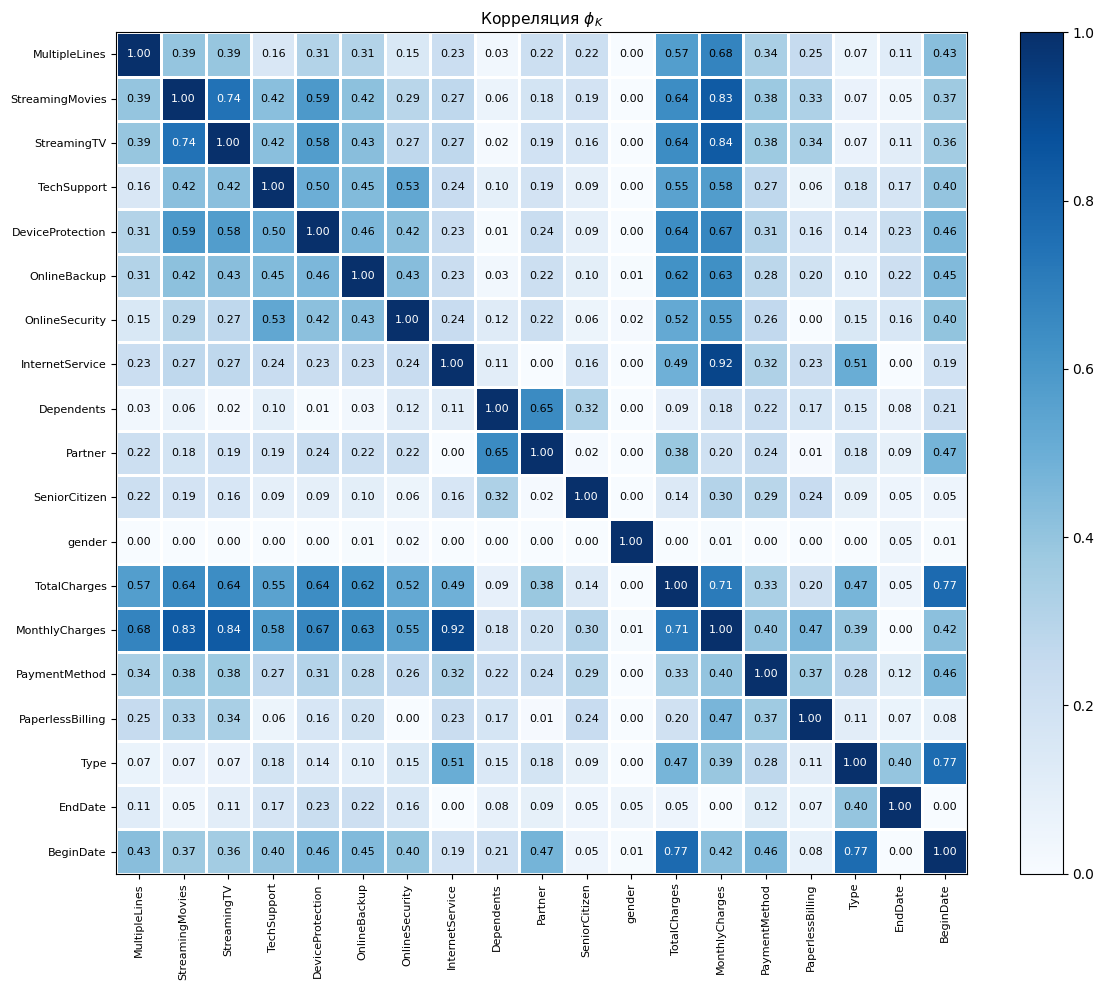

In [54]:
plot_correlation_matrix(phik_corr.values, 
                        x_labels=phik_corr.columns, 
                        y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()